<a href="https://colab.research.google.com/github/LucianaNieto/Cambodia_2023/blob/main/2_SemanticSegmentation_Cambodia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.10 -q
!pip install patchify -q
!pip install segmentation_models==0.2.1 -q
import tensorflow
tensorflow.__version__
!pip install segmentation_models==1.0.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 10.6 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_directory = '/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/'

In [5]:
patch_size = 512

In [6]:

# set the path of the folder containing the images
image_folder_path = "/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/aug_images_train"

# set the path of the folder containing the masks
mask_folder_path = "/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/aug_masks_train"

# count the number of files in the folder
num_files = len(os.listdir(mask_folder_path))

# print the result
print(f"The folder '{mask_folder_path}' contains {num_files} files.")


The folder '/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/aug_masks_train' contains 1296 files.


In [7]:
# get a list of all the image and mask file names
image_files = sorted(os.listdir(image_folder_path))
mask_files = sorted(os.listdir(mask_folder_path))

# make sure the number of images and masks are equal
assert len(image_files) == len(mask_files), "The number of images and masks are not equal"

# create empty numpy arrays to store the images and masks
images_np = np.zeros((len(image_files), 512, 512, 3), dtype=np.uint8)
masks_np = np.zeros((len(mask_files), 512, 512, 3), dtype=np.uint8)

# loop through each image and mask file and convert them to numpy arrays
for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
    #print(f"Processing files {i+1}/{len(image_files)}: {image_file}, {mask_file}")
    image_path = os.path.join(image_folder_path, image_file)
    mask_path = os.path.join(mask_folder_path, mask_file)
    image = Image.open(image_path).resize((512, 512))
    mask = Image.open(mask_path).resize((512, 512))
    image_np = np.array(image, dtype=np.uint8)
    mask_np = np.array(mask, dtype=np.uint8)
    images_np[i] = image_np
    masks_np[i] = mask_np

# check if the images and masks are aligned
assert images_np.shape[0] == masks_np.shape[0], "The number of images and masks are not equal"
assert images_np.shape[1:3] == masks_np.shape[1:3], "The images and masks are not aligned"


In [8]:
masks_np.shape

(1296, 512, 512, 3)

In [9]:
images_np.shape

(1296, 512, 512, 3)

In [10]:
"""
#3366CC (51, 102, 204) blueish road
#FF9900 (255, 153, 0) orange vegetation
#109618 (16, 150, 24) green forest
#990099 (153, 0, 153) purple burned
#0099C6 (0, 153, 198) lightblue baredsoil
#DD4477 (221, 68, 119) pink unclass              
"""
#Convert HEX to RGB array
#Do the same for all RGB channels in each hex code to convert to RGB
Road = '#3366CC'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) # 51, 102, 204

Vegetation = '#FF9900'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #255, 153, 0

Forest = '#109618'.lstrip('#') 
Forest = np.array(tuple(int(Forest[i:i+2], 16) for i in (0, 2, 4))) #16, 150, 24

Burned =  '#990099'.lstrip('#') 
Burned = np.array(tuple(int(Burned[i:i+2], 16) for i in (0, 2, 4))) #153, 0, 153

Bare = '#0099C6'.lstrip('#') 
Bare = np.array(tuple(int(Bare[i:i+2], 16) for i in (0, 2, 4))) #0, 153, 198

Unlabeled = '#DD4477'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #221, 68, 119

#label = single_patch_mask
label = mask_np
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Road,axis=-1)] = 0
    label_seg [np.all(label==Vegetation,axis=-1)] = 1
    label_seg [np.all(label==Forest,axis=-1)] = 2
    label_seg [np.all(label==Burned,axis=-1)] = 3
    label_seg [np.all(label==Bare,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(masks_np.shape[0]):
    label = rgb_to_2D_label(masks_np[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [11]:
labels.shape

(1296, 512, 512, 1)

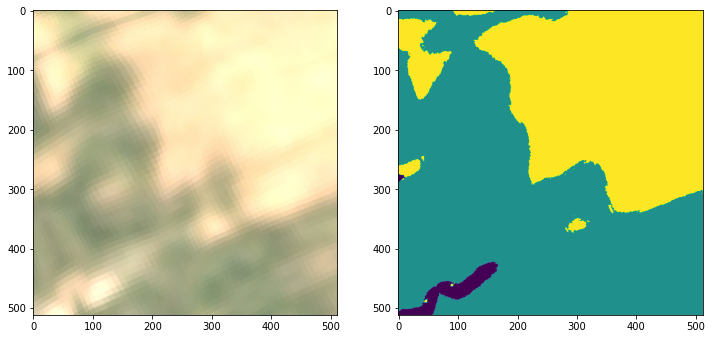

In [ ]:
#Another Sanity check, view few mages

image_number = random.randint(0, len(images_np))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(images_np[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [12]:
##########new type of data ############
#from sklearn.utils.class_weight import compute_class_weight
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)



In [ ]:

dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


In [ ]:
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=18, 
          epochs=150,
          verbose=1,
          validation_data=(X_test_prepr, y_test))


85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

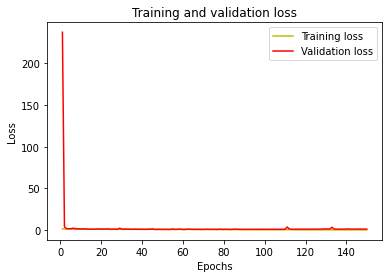

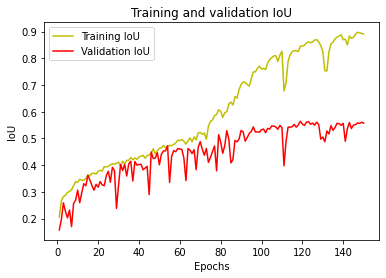

In [ ]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


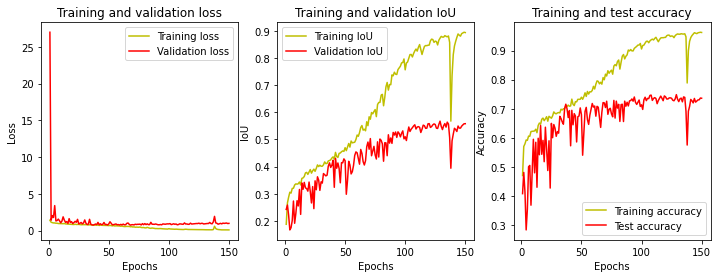

In [ ]:
import matplotlib.pyplot as plt

# get history from model training
history = history2

# extract training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# extract training and validation IoU
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

# extract training and test accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy'] ###

# create x-axis values for epochs
epochs = range(1, len(loss) + 1)

# plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot training and validation IoU
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# plot training and test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, train_acc, 'y', label='Training accuracy')
plt.plot(epochs, test_acc, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, jaccard_score
import numpy as np
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

# Define number of folds
k = 4

# Define the data and labels
data = images_np
labels = labels_cat

# Initialize the K-fold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define the ResNet model to be trained
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_jacard_coefs = []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")

    # Split data into training and test sets for this fold
    X_train = data[train_idx]
    y_train = labels[train_idx]
    X_test = data[test_idx]
    y_test = labels[test_idx]

    # Fit the model on the training data
    model_resnet_backbone.fit(
        x=preprocess_input(X_train),
        y=y_train,
        batch_size=8,
        epochs=120,
        validation_data=(preprocess_input(X_test), y_test)
    )

    # Get predictions for test set
    y_pred = model_resnet_backbone.predict(preprocess_input(X_test))
    y_pred_labels = np.argmax(y_pred, axis=-1)

    # Calculate accuracy and Jaccard coefficient
    accuracy = accuracy_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    jacard_coef = jaccard_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')

    # Print metrics for this fold
    print("Fold accuracy:", accuracy)
    print("Fold Jaccard coefficient:", jacard_coef)

    # Add metrics to lists for all folds
    fold_accuracies.append(accuracy)
    fold_jacard_coefs.append(jacard_coef)

    # Clear memory
    del X_train, y_train, X_test, y_test, y_pred, y_pred_labels
    gc.collect()

# Print average metrics across all folds
print("Average accuracy:", np.mean(fold_accuracies))
print("Average Jaccard coefficient:", np.mean(fold_jacard_coefs))



85521592/85521592 [==============================] - 1s 0us/step
Fold 1
Epoch 1/120
122/122 [==============================] - 40s 196ms/step - loss: 1.3939 - accuracy: 0.4657 - jacard_coef: 0.1955 - val_loss: 1.6136 - val_accuracy: 0.4065 - val_jacard_coef: 0.1448
Epoch 2/120
122/122 [==============================] - 19s 152ms/step - loss: 1.2386 - accuracy: 0.5135 - jacard_coef: 0.2338 - val_loss: 1.3439 - val_accuracy: 0.4820 - val_jacard_coef: 0.1956
Epoch 3/120
122/122 [==============================] - 19s 152ms/step - loss: 1.2235 - accuracy: 0.5200 - jacard_coef: 0.2401 - val_loss: 4.3310 - val_accuracy: 0.3560 - val_jacard_coef: 0.1853
Epoch 4/120
122/122 [==============================] - 18s 152ms/step - loss: 1.1918 - accuracy: 0.5277 - jacard_coef: 0.2508 - val_loss: 1.1409 - val_accuracy: 0.5563 - val_jacard_coef: 0.2428
Epoch 5/120
122/122 [==============================] - 19s 152ms/step - loss: 1.1639 - accuracy: 0.5422 - jacard_coef: 0.2594 - val_loss: 1.4557 - val_a

In [13]:
############ THIS TO ALSO HAVE F-Score and confusion matrix 
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, f1_score
import numpy as np
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

# Define number of folds
k = 4

# Define the data and labels
data = images_np
labels = labels_cat

# Initialize the K-fold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define the ResNet model to be trained
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_jacard_coefs = []
fold_f1_scores = []
fold_confusion_matrices = []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")

    # Split data into training and test sets for this fold
    X_train = data[train_idx]
    y_train = labels[train_idx]
    X_test = data[test_idx]
    y_test = labels[test_idx]

    # Fit the model on the training data
    model_resnet_backbone.fit(
        x=preprocess_input(X_train),
        y=y_train,
        batch_size=8,
        epochs=120,
        validation_data=(preprocess_input(X_test), y_test)
    )

    # Get predictions for test set
    y_pred = model_resnet_backbone.predict(preprocess_input(X_test))
    y_pred_labels = np.argmax(y_pred, axis=-1)

    # Calculate accuracy, Jaccard coefficient, confusion matrix, and F-1 score
    accuracy = accuracy_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    jacard_coef = jaccard_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')
    confusion_matrix_values = confusion_matrix(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    f1 = f1_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')

    # Print metrics for this fold
    print("Fold accuracy:", accuracy)
    print("Fold Jaccard coefficient:", jacard_coef)
    print("Fold confusion matrix:", confusion_matrix_values)
    print("Fold F-1 score:", f1)

    # Add metrics to lists for all folds
    fold_accuracies.append(accuracy)
    fold_jacard_coefs.append(jacard_coef)
    fold_f1_scores.append(f1)
    fold_confusion_matrices.append(confusion_matrix_values)
    # Clear memory
    del X_train, y_train, X_test, y_test, y_pred, y_pred_labels
    gc.collect()




85521592/85521592 [==============================] - 18s 0us/step
Fold 1
Epoch 1/120
122/122 [==============================] - 97s 653ms/step - loss: 1.3770 - accuracy: 0.4650 - jacard_coef: 0.1948 - val_loss: 16316.2637 - val_accuracy: 0.3276 - val_jacard_coef: 0.1908
Epoch 2/120
122/122 [==============================] - 71s 581ms/step - loss: 1.2330 - accuracy: 0.5258 - jacard_coef: 0.2423 - val_loss: 10.6336 - val_accuracy: 0.2237 - val_jacard_coef: 0.1190
Epoch 3/120
122/122 [==============================] - 71s 582ms/step - loss: 1.1880 - accuracy: 0.5475 - jacard_coef: 0.2574 - val_loss: 12.9561 - val_accuracy: 0.3888 - val_jacard_coef: 0.2217
Epoch 4/120
122/122 [==============================] - 71s 582ms/step - loss: 1.1862 - accuracy: 0.5507 - jacard_coef: 0.2562 - val_loss: 3.2156 - val_accuracy: 0.3835 - val_jacard_coef: 0.2538
Epoch 5/120
122/122 [==============================] - 71s 580ms/step - loss: 1.1517 - accuracy: 0.5603 - jacard_coef: 0.2674 - val_loss: 3.6033 

ResourceExhaustedError: ignored

In [ ]:
# Print average metrics across all folds
print("Average accuracy:", np.mean(fold_accuracies))
print("Average Jaccard coefficient:", np.mean(fold_jacard_coefs))
print("Average f1:", np.mean(fold_f1_scores))
print("Average matrix:", np.mean(fold_confusion_matrices))

In [ ]:
fold_confusion_matrices

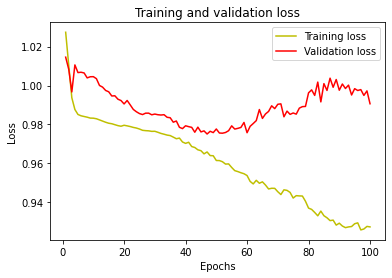

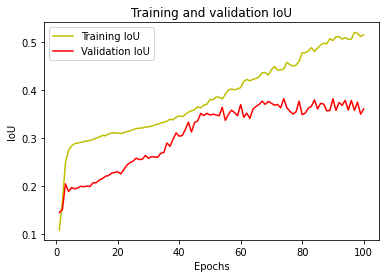

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


6/6 [==============================] - 0s 20ms/step
Mean IoU = 0.27371755
1/1 [==============================] - 0s 25ms/step


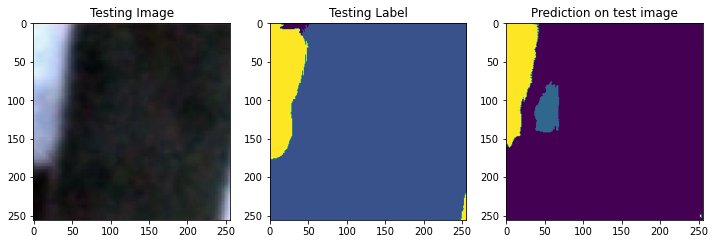

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()